In [1]:
# Libraries
import datetime as dt
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Download Yahoo Finance data
ticker = 'NVDA'
start_date = dt.datetime(2016, 1, 1)
end_date = dt.datetime(2025, 10, 31)
data = yf.download(ticker, start=start_date, end=end_date)

C:\Users\warre\AppData\Local\Temp\ipykernel_22896\1679449339.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


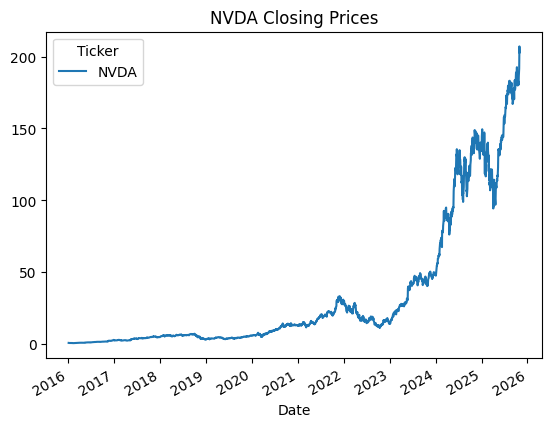

In [2]:
data['Close'].plot()
plt.title(f'{ticker} Closing Prices')
plt.show()

In [3]:
data[('log_ret', ticker)] = np.log(data['Close'] / data['Close'].shift(1))
df = data.copy()
df.dropna(inplace=True)
df.head()

Price,Close,High,Low,Open,Volume,log_ret
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,,
2016-01-05,0.802317,0.815733,0.792803,0.804512,490272000,0.015937
2016-01-06,0.769141,0.792803,0.760115,0.789144,449344000,-0.042229
2016-01-07,0.738648,0.754992,0.728891,0.749869,645304000,-0.040452
2016-01-08,0.722792,0.748894,0.721329,0.748162,398472000,-0.021700
2016-01-11,0.724012,0.729135,0.711083,0.723524,409372000,0.001686


In [4]:
returns = df['log_ret'].values

mean_returns = returns.mean()

var_returns = returns.var()

sd_returns = np.sqrt(var_returns)

print(f'Mean Daily Return: {mean_returns}')
print(f'Variance of Daily Returns: {var_returns}')
print(f'Standard Deviation of Daily Returns: {sd_returns}')

Mean Daily Return: 0.0022455898404187273
Variance of Daily Returns: 0.0009826495368607585
Standard Deviation of Daily Returns: 0.03134724129585821


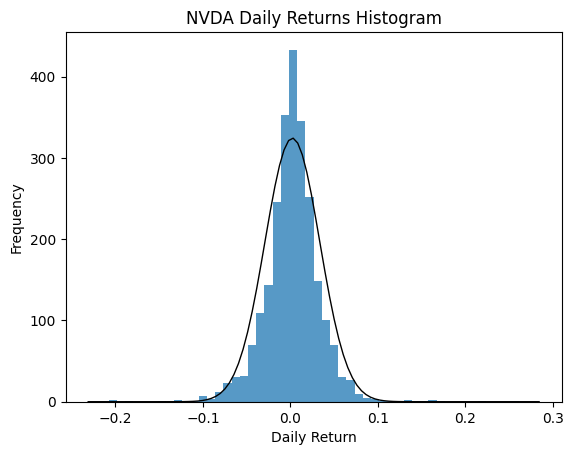

In [5]:
# plot the returns on a histogram
plt.hist(df[('log_ret', ticker)], bins=50, alpha=0.75)
plt.title(f'{ticker} Daily Returns Histogram')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')

# plot the normal distribution with mean `mean_returns` and standard deviation `sd_returns`
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = np.exp(-0.5 * ((x - mean_returns) / sd_returns) ** 2) / (sd_returns * np.sqrt(2 * np.pi))
plt.plot(x, p * len(data[('log_ret', ticker)]) * (xmax - xmin) / 50, 'k', linewidth=1)

plt.show()


$$
    \providecommand{\calF}{\mathcal{F}}
    \providecommand{\eps}{\varepsilon}
    \providecommand{\exp}{\text{\exp}}
$$

We will now implement the ARCH(1) model. We assume our returns are given by
$$
\begin{align*}
    r_t &= \mu + \eps_t, \\
    \eps_t &= \sigma_t z_t, \quad z_t \overset{\text{i.i.d.}}{\sim} N(0, 1), \\
    \sigma_t^2 &= \omega + \alpha\eps_{t-1}^2. 
\end{align*}
$$

Note that we need to *choose* a variance for $t = 1$.

Given the information $\calF_{t-1} = \set{\eps_1, \eps_2, \dots, \eps_{t-1}}$, the ARCH model says that $\eps_t$ follows a normal distribution $f(\eps_t ~ \vert ~ \calF_{t-1}) = N(0, \sigma_t^2)$.

Now, we should find $\mathbb{E}[\sigma_t^2]$:
$$
\begin{align*}
    \mathbb{E}[\sigma_t^2] &= \omega + \alpha\mathbb{E}[\eps_{t-1}^2] \\
    &= \omega + \alpha\mathbb{E}[\sigma_{t-1}^2] \\
    &= \omega + \alpha\mathbb{E}[\sigma_t^2].
\end{align*}
$$
If this process runs forever, we will have
$$
    \mathbb{E}[\sigma_t^2] = \frac{\omega}{1-\alpha}.
$$

---

The PDF for the time series $\set{\eps_1, \eps_2, \dots, \eps_T}$ is:
$$
    f(\eps_1, \eps_2, \dots, \eps_T) = f(x_1) f(x_2) \cdots f(x_T), 
$$
where $x_t \sim N(0, \sigma_t^2)$, so
$$
    f(\eps_1, \eps_2, \dots, \eps_T) = \prod_{t=1}^T \frac{1}{\sqrt{2\pi\sigma_t^2}}\exp(-\frac{\eps_t^2}{2\sigma_t^2}).
$$
The **log-likelihood** is the log of this PDF, which will turn the PDF from *products* into *sums*. It is dependent on each $\sigma_t$, or $\omega$ and $\alpha$:
$$
    \ell(\omega, \alpha) = -\frac{1}{2}\sum_{t=1}^T\left[\log(2\pi) + \log(\sigma_t^2) + \frac{\eps^2}{\sigma_t^2} \right]
$$
This is easier to work with and does not change the maximiser, since $\log$ is a strictly increasing function.

We want to find $\hat{\omega}$ and $\hat{\alpha}$ that maximise $\ell$ (or minimise $-\ell$, the *negative log-likelihood*).

In [ ]:
# implement the ARCH(1) model

def arch_variance(omega, alpha, eps_sq):
    """
    Returns an array of conditional variances for ARCH(1).
    """
    T = len(eps_sq)
    sigma_sq = np.zeros(T)
    sigma_sq[0] = omega / (1 - alpha)  # initial variance, use the expected long-term variance given our parameters
    for t in range(1, T):
        sigma_sq[t] = omega + alpha * np.squeeze(eps_sq[t-1])
    return sigma_sq

def neg_log_likelihood(sigma_sq, eps_sq):
    """
    Returns the negative log-likelihood (NLL) for the ARCH(1) model.
    """
    T = len(eps_sq)
    nll = 0.5 * np.sum(np.log(2 * np.pi) + np.log(sigma_sq) + eps_sq / sigma_sq)
    return nll

eps = (returns - mean_returns).squeeze() # array of residuals
eps_sq = eps**2                          # squared residuals

# we will do a 'grid search' to find the optimal omega and alpha that minimise `neg_log_likelihood`
COARSENESS = 50

omega_values = np.linspace(0.1 * eps.var(), 2.0 * eps.var(), COARSENESS)
alpha_values = np.linspace(0, 0.9, COARSENESS)

min_nll = np.inf
optimal_params = (None, None)

# loop through all combinations of omega and alpha, and store the minimum NLL and corresponding parameters
for omega in omega_values:
    for alpha in alpha_values:
        sigma_sq = arch_variance(omega, alpha, eps_sq)
        nll = neg_log_likelihood(sigma_sq, eps_sq)
        if nll < min_nll:
            min_nll = nll
            optimal_params = (float(omega), float(alpha))


print("Best grid params:", optimal_params, "with NLL:", min_nll)

Best grid params: (0.0007841142222705236, 0.22040816326530616) with NLL: -5100.817887357141


We have our model:
$$
    \sigma_t^2 = 0.00078412 + 0.22040816\eps_{t-1}^2. 
$$
with the fitted estimates $\hat{\omega} = 0.00078412$ and $\hat{\alpha} = 0.22040816$.